# Deep Learning - Homework 04

### Roberto Corti




In [2]:
### GOOGLE DRIVE 

from google.colab import drive

folder_mount = '/content/drive' # Your Drive will be mounted on top of this path

drive.mount(folder_mount)

%cd drive/MyDrive/Università/DSSC/Secondo\ Anno/Deep-Learning/homeworks/

Mounted at /content/drive
/content/drive/MyDrive/Università/DSSC/Secondo Anno/Deep-Learning/homeworks


1. Now that you have all the tools to train an MLP with high performance on MNIST, try reaching 0-loss (or 100% accuracy) on the training data (with a small epsilon, e.g. 99.99% training performance -- don't worry if you overfit!). The implementation is completely up to you. You just need to keep it an MLP without using fancy layers (e.g., keep the Linear layers, don't use Conv1d or something like this, don't use attention). You are free to use any LR scheduler or optimizer, any one of batchnorm/groupnorm, regularization methods... If you use something we haven't seen during lectures, please motivate your choice and explain (as briefly as possible) how it works.

In [3]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import random
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

In order to reach 0-loss on the training data, as first decision that I have to make is related to the **mini-batch size**. 

Let's recap some useful information about the choice of this hyperparameter

* It has been proven in practice that a large batch size will lead to poor generalization 

* Using a batch equal to the entire dataset guarantees convergence to the global optima of the objective function

*  Small batch size have been empirically shown to have faster convergence, but it does not guarantee the convergence to the global optima


Since in this exercise our aim is not to generalize but to converge to the optimal choice of the weights of our network, I decide to use a mini batch size larger than the usual, equal to 512

In [15]:
## Get MNIST data
'''
# https://stackoverflow.com/questions/66646604/http-error-503-service-unavailable-whan-trying-to-download-mnist-data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

'''
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
minibatch_size_train = 512
minibatch_size_test = 512


# Trasformations
transforms = Compose([
                      ToTensor(),
                      Normalize((0.1307,), (0.3081,))
                    ])

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms)



# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=minibatch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=minibatch_size_test, 
                                          shuffle=False)


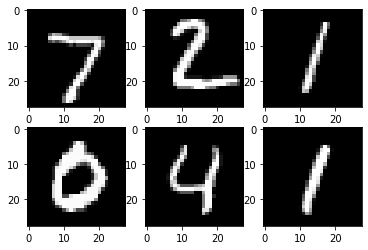

In [16]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

The structure of the multi-layer perceptron that I chose for this problem is made up by only a single hidden layer but with a large number of neurons equal to 1024. Moreover, I observed that the use of a Batch-Normalization layer will help the model to converge faster



In [20]:
# Fully connected neural network with 1 hidden layer, inputsize=28*28, output
class MLP(nn.Module):
  '''
  Fully connected neural network with 1 hidden layer + Batch Normalization.
  Input size: 784
  Output size: 10
  '''
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.h1 = nn.Linear(28*28, 1024)
    self.bout = nn.BatchNorm1d(num_features=1024)    
    self.out = nn.Linear(1024, 10)

  def forward(self, X, activ_hidden=nn.functional.relu):
    out = self.flat(X)
    out = activ_hidden(self.h1(out))
    out = self.bout(out)
    out = self.out(out)
    return out

In [21]:
# Model
model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Number of epochs
num_epochs = 15


# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [512, 1, 28, 28]
        # resized: [512, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    scheduler.step()

# Evaluate the model on train set
# In tthis phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'\n\nAccuracy of the network on the train set: {acc:.3f} %')


Epoch [1/15], Step [50/118], Loss: 0.1700
Epoch [1/15], Step [100/118], Loss: 0.1800
Epoch [2/15], Step [50/118], Loss: 0.1088
Epoch [2/15], Step [100/118], Loss: 0.0543
Epoch [3/15], Step [50/118], Loss: 0.0389
Epoch [3/15], Step [100/118], Loss: 0.0471
Epoch [4/15], Step [50/118], Loss: 0.0423
Epoch [4/15], Step [100/118], Loss: 0.0202
Epoch [5/15], Step [50/118], Loss: 0.0107
Epoch [5/15], Step [100/118], Loss: 0.0169
Epoch [6/15], Step [50/118], Loss: 0.0244
Epoch [6/15], Step [100/118], Loss: 0.0134
Epoch [7/15], Step [50/118], Loss: 0.0096
Epoch [7/15], Step [100/118], Loss: 0.0216
Epoch [8/15], Step [50/118], Loss: 0.0165
Epoch [8/15], Step [100/118], Loss: 0.0050
Epoch [9/15], Step [50/118], Loss: 0.0053
Epoch [9/15], Step [100/118], Loss: 0.0150
Epoch [10/15], Step [50/118], Loss: 0.0032
Epoch [10/15], Step [100/118], Loss: 0.0028
Epoch [11/15], Step [50/118], Loss: 0.0010
Epoch [11/15], Step [100/118], Loss: 0.0063
Epoch [12/15], Step [50/118], Loss: 0.0044
Epoch [12/15], Ste

After 10 epochs the model is able to have a 99% accuracy on the training set.

2. Try reaching 0-loss on the training data with permuted labels. Assess the model on the test data (without permuted labels) and comment.

For this problem I will use a larger batch size equal to 1024.

The reason of that is due to the fact that now data are randomly grouped and in order to get some information of this new decision boundary the network will require more data for each training step

In [37]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
minibatch_size_train = 1024
minibatch_size_test = 512


# Trasformations
transforms = Compose([
                      ToTensor(),
                      Normalize((0.1307,), (0.3081,))
                    ])

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms)

To permute labels of the training set I followed these two steps:

* Use the `shuffle` function (provided by the `random` package) on the index of the training set and save it into `shuffled_index`

* Apply `shuffled_index` on the data member `target` of the train dataset class istance.

In [38]:
index = [i for i in range(len(train_dataset))]
random.shuffle(index)
train_dataset.targets = train_dataset.targets[index]


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=minibatch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=minibatch_size_test, 
                                          shuffle=False)

Since this new classification problem seems to be more complex, I decide to add to the previous network a new hidden layer. The size of the hidden layers will be now 3000 and 1024.

In [39]:
class MLP(nn.Module):
  '''
  Fully connected neural network with 2 hidden layer + Batch Normalization.
  Input size: 784
  Output size: 10
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(784, 3000),
        nn.ReLU(),
        nn.BatchNorm1d(3000),
        nn.Linear(3000, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024,10)
    )
  def forward(self, x):
    return (self.layers(x.view(-1,784)))

In [42]:
# Model
model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Number of epochs
num_epochs = 50


# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      # origin shape: [512, 1, 28, 28]
      # resized: [512, 784]
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      if (i+1) % 50 == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    scheduler.step()

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, (images, labels) in enumerate(train_loader):
      if i == 0:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'\n\nAccuracy of the network on the train set: {acc:.3f} %')

Epoch [1/50], Step [50/59], Loss: 2.3314
Epoch [2/50], Step [50/59], Loss: 2.3031
Epoch [3/50], Step [50/59], Loss: 2.2913
Epoch [4/50], Step [50/59], Loss: 2.2774
Epoch [5/50], Step [50/59], Loss: 2.2711
Epoch [6/50], Step [50/59], Loss: 2.2662
Epoch [7/50], Step [50/59], Loss: 2.2329
Epoch [8/50], Step [50/59], Loss: 2.1777
Epoch [9/50], Step [50/59], Loss: 2.1185
Epoch [10/50], Step [50/59], Loss: 2.1078
Epoch [11/50], Step [50/59], Loss: 2.0114
Epoch [12/50], Step [50/59], Loss: 1.9550
Epoch [13/50], Step [50/59], Loss: 1.8718
Epoch [14/50], Step [50/59], Loss: 1.7192
Epoch [15/50], Step [50/59], Loss: 1.5747
Epoch [16/50], Step [50/59], Loss: 1.3472
Epoch [17/50], Step [50/59], Loss: 1.2216
Epoch [18/50], Step [50/59], Loss: 0.9697
Epoch [19/50], Step [50/59], Loss: 0.8361
Epoch [20/50], Step [50/59], Loss: 0.6737
Epoch [21/50], Step [50/59], Loss: 0.5443
Epoch [22/50], Step [50/59], Loss: 0.4253
Epoch [23/50], Step [50/59], Loss: 0.3378
Epoch [24/50], Step [50/59], Loss: 0.2975
E